
# Estimate anisotropy in a 3D microscopy image

In this tutorial, we compute the structure tensor of a 3D image.
For a general introduction to 3D image processing, please refer to
`sphx_glr_auto_examples_applications_plot_3d_image_processing.py`.
The data we use here are sampled from an image of kidney tissue obtained by
confocal fluorescence microscopy (more details at [1]_ under
``kidney-tissue-fluorescence.tif``).

.. [1] https://gitlab.com/scikit-image/data/#data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io

from skimage import (
    data, feature
)

## Load image
This biomedical image is available through `scikit-image`'s data registry.



In [2]:
data = data.kidney()

What exactly are the shape and size of our 3D multichannel image?



In [3]:
print(f'number of dimensions: {data.ndim}')
print(f'shape: {data.shape}')
print(f'dtype: {data.dtype}')

number of dimensions: 4
shape: (16, 512, 512, 3)
dtype: uint16


For the purposes of this tutorial, we shall consider only the second color
channel, which leaves us with a 3D single-channel image. What is the range
of values?



In [4]:
n_plane, n_row, n_col, n_chan = data.shape
v_min, v_max = data[:, :, :, 1].min(), data[:, :, :, 1].max()
print(f'range: ({v_min}, {v_max})')

range: (68, 4095)


Let us visualize the middle slice of our 3D image.



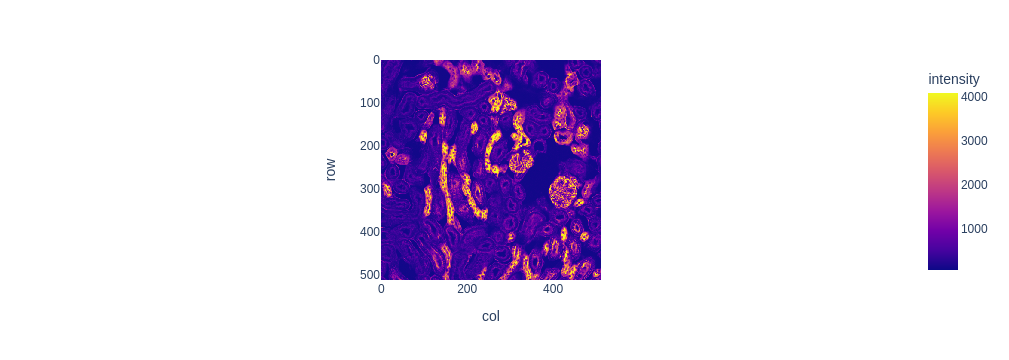

In [5]:
fig1 = px.imshow(
    data[n_plane // 2, :, :, 1],
    zmin=v_min,
    zmax=v_max,
    labels={'x': 'col', 'y': 'row', 'color': 'intensity'}
)

plotly.io.show(fig1)

Let us pick a specific region, which shows relative X-Y isotropy. In
contrast, the gradient is quite different (and, for that matter, weak) along
Z.



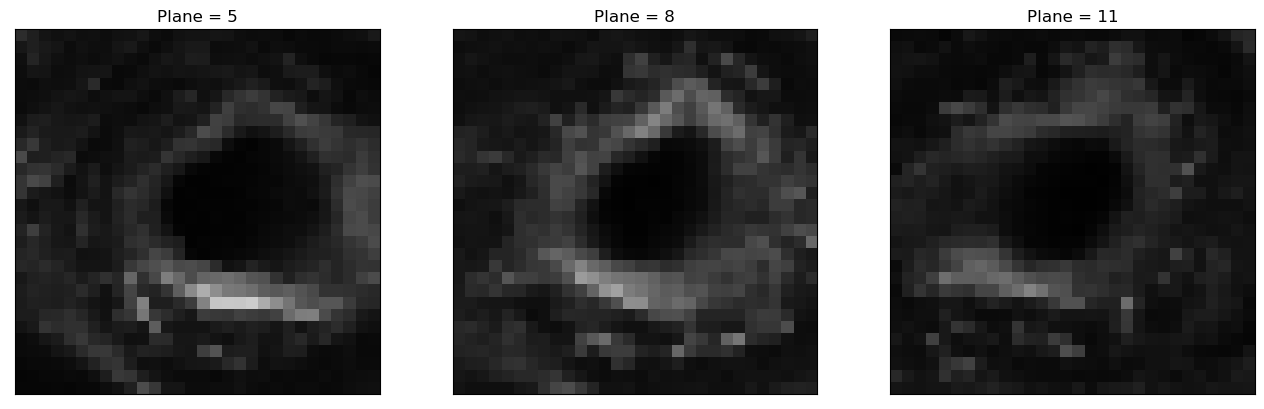

In [6]:
sample = data[5:13, 380:410, 370:400, 1]
step = 3
cols = sample.shape[0] // step + 1
_, axes = plt.subplots(nrows=1, ncols=cols, figsize=(16, 8))

for it, (ax, image) in enumerate(zip(axes.flatten(), sample[::step])):
    ax.imshow(image, cmap='gray', vmin=v_min, vmax=v_max)
    ax.set_title(f'Plane = {5 + it * step}')
    ax.set_xticks([])
    ax.set_yticks([])

To view the sample data in 3D, run the following code:

```python
import plotly.graph_objects as go

(n_Z, n_Y, n_X) = sample.shape
Z, Y, X = np.mgrid[:n_Z, :n_Y, :n_X]

fig = go.Figure(
    data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=sample.flatten(),
        opacity=0.5,
        slices_z=dict(show=True, locations=[4])
    )
)
fig.show()
```


## Compute structure tensor
Let us visualize the bottom slice of our sample data and determine the
typical size for strong variations. We shall use this size as the
'width' of the window function.



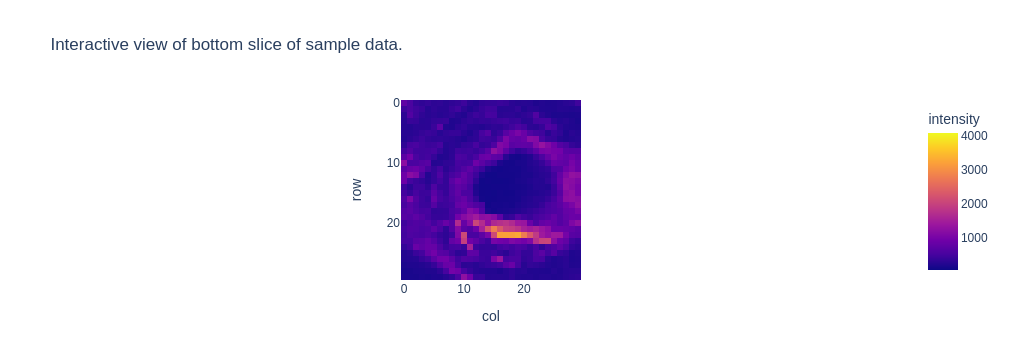

In [7]:
fig2 = px.imshow(
    sample[0, :, :],
    zmin=v_min,
    zmax=v_max,
    labels={'x': 'col', 'y': 'row', 'color': 'intensity'},
    title='Interactive view of bottom slice of sample data.'
)

plotly.io.show(fig2)

About the brightest region (i.e., at row ~ 22 and column ~ 17), we can see
variations (and, hence, strong gradients) over 2 or 3 (resp. 1 or 2) pixels
across columns (resp. rows). We may thus choose, say, ``sigma = 1.5`` for
the window
function. Alternatively, we can pass sigma on a per-axis basis, e.g.,
``sigma = (1, 2, 3)``. Note that size 1 sounds reasonable along the first
(Z, plane) axis, since the latter is of size 8 (13 - 5). Viewing slices in
the X-Z or Y-Z planes confirms it is reasonable.



In [8]:
sigma = (1, 1.5, 2.5)
A_elems = feature.structure_tensor(sample, sigma=sigma)

We can then compute the eigenvalues of the structure tensor.



In [9]:
eigen = feature.structure_tensor_eigenvalues(A_elems)
eigen.shape

(3, 8, 30, 30)

Where is the largest eigenvalue?



In [10]:
coords = np.unravel_index(eigen.argmax(), eigen.shape)
assert coords[0] == 0  # by definition
coords

(0, 1, 22, 16)

<div class="alert alert-info"><h4>Note</h4><p>The reader may check how robust this result (coordinates
   ``(plane, row, column) = coords[1:]``) is to varying ``sigma``.</p></div>

Let us view the spatial distribution of the eigenvalues in the X-Y plane
where the maximum eigenvalue is found (i.e., ``Z = coords[1]``).



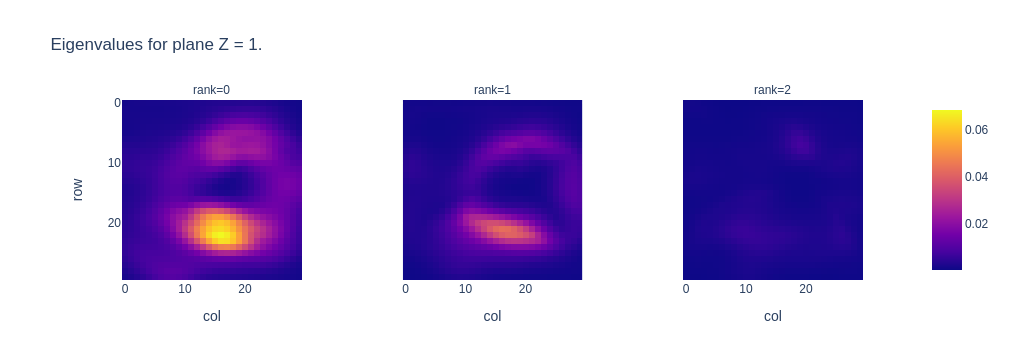

In [11]:
fig3 = px.imshow(
    eigen[:, coords[1], :, :],
    facet_col=0,
    labels={'x': 'col', 'y': 'row', 'facet_col': 'rank'},
    title=f'Eigenvalues for plane Z = {coords[1]}.'
)

plotly.io.show(fig3)

We are looking at a local property. Let us consider a tiny neighborhood
around the maximum eigenvalue in the above X-Y plane.



In [12]:
eigen[0, coords[1], coords[2] - 2:coords[2] + 1, coords[3] - 2:coords[3] + 1]

array([[0.05530323, 0.05929082, 0.06043806],
       [0.05922725, 0.06268274, 0.06354238],
       [0.06190861, 0.06685075, 0.06840962]])

If we examine the second-largest eigenvalues in this neighborhood, we can
see that they have the same order of magnitude as the largest ones.



In [13]:
eigen[1, coords[1], coords[2] - 2:coords[2] + 1, coords[3] - 2:coords[3] + 1]

array([[0.03577746, 0.03577334, 0.03447714],
       [0.03819524, 0.04172036, 0.04323701],
       [0.03139592, 0.03587025, 0.03913327]])

In contrast, the third-largest eigenvalues are one order of magnitude
smaller.



In [14]:
eigen[2, coords[1], coords[2] - 2:coords[2] + 1, coords[3] - 2:coords[3] + 1]

array([[0.00337661, 0.00306529, 0.00276288],
       [0.0041869 , 0.00397519, 0.00375595],
       [0.00479742, 0.00462116, 0.00442455]])

Let us visualize the slice of sample data in the X-Y plane where the
maximum eigenvalue is found.



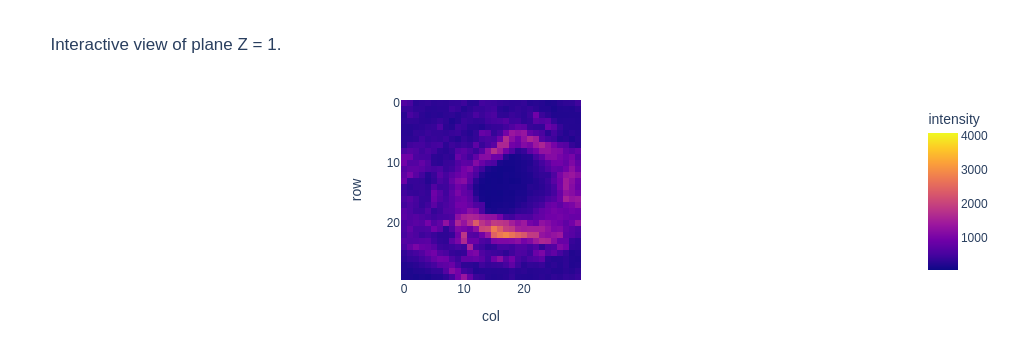

In [15]:
fig4 = px.imshow(
    sample[coords[1], :, :],
    zmin=v_min,
    zmax=v_max,
    labels={'x': 'col', 'y': 'row', 'color': 'intensity'},
    title=f'Interactive view of plane Z = {coords[1]}.'
)

plotly.io.show(fig4)

Let us visualize the slices of sample data in the X-Z (left) and Y-Z (right)
planes where the maximum eigenvalue is found. The Z axis is the vertical
axis in the subplots below. We can see the expected relative invariance
along the Z axis (corresponding to longitudinal structures in the kidney
tissue), especially in the Y-Z plane (``longitudinal=1``).



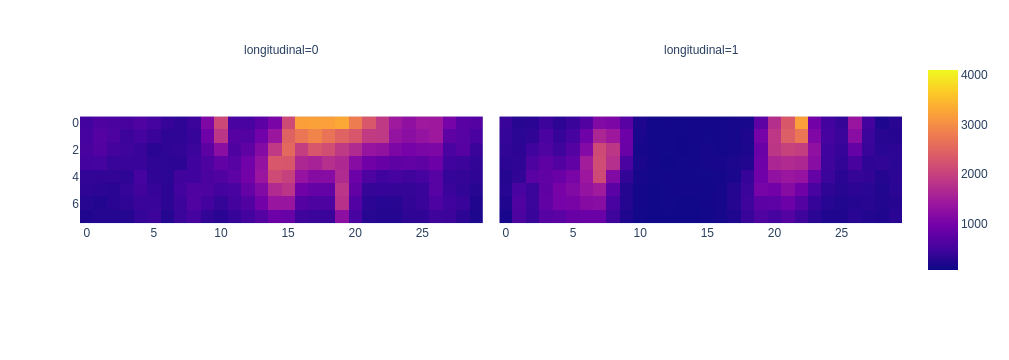

In [16]:
subplots = np.dstack((sample[:, coords[2], :], sample[:, :, coords[3]]))
fig5 = px.imshow(
    subplots,
    zmin=v_min,
    zmax=v_max,
    facet_col=2,
    labels={'facet_col': 'longitudinal'}
)

plotly.io.show(fig5)

As a conclusion, the region about voxel
``(plane, row, column) = coords[1:]`` is
anisotropic in 3D: There is an order of magnitude between the third-largest
eigenvalues on one hand, and the largest and second-largest eigenvalues on
the other hand. We could see this at first glance in figure `Eigenvalues for
plane Z = 1`.



The neighborhood in question is 'somewhat isotropic' in a plane (which,
here, would be relatively close to the X-Y plane): There is a factor of
less than 2 between the second-largest and largest eigenvalues.
This description is compatible with what we are seeing in the image, i.e., a
stronger gradient across a direction (which, here, would be relatively close
to the row axis) and a weaker gradient perpendicular to it.



In an ellipsoidal representation of the 3D structure tensor [2]_,
we would get the pancake situation.

.. [2] https://en.wikipedia.org/wiki/Structure_tensor#Interpretation_2

